# Advanced: Iterating over genomes with PatMatch

The [previous notebook, 'Advanced: Sending PatMatch output directly to Python'](Sending%20PatMatch%20output%20directly%20to%20Python.ipynb), 
covered leveraging the the Jupyter environment to skip over needing to save a file to actually pass results from shell scripts into Python. This notebook will demonstrate using one of those approaches to iterate over several genomes.   
This builds on other aspects seen in the early notebooks too.

## Preparing

Similar to the previous notebook, in order to insure everything is all set, act as if this is a new session in this Jupyter environment, and run the next cell so that you can start stepping through the preparation steps by first getting a sequence file. Plus, you'll get the files for scripts to convert it to dataframe and plot sites across a chromosome and import the main functions of those scripts. 

Repeating these steps if you had already done so this session will cause no harm, and so go ahead and run this cell.

In [1]:
!curl -O https://downloads.yeastgenome.org/sequence/S288C_reference/chromosomes/fasta/chrmt.fsa
!curl -O https://raw.githubusercontent.com/fomightez/sequencework/master/patmatch-utilities/patmatch_results_to_df.py
from patmatch_results_to_df import patmatch_results_to_df
!curl -O https://raw.githubusercontent.com/fomightez/sequencework/master/plot_sites/plot_sites_position_across_chromosome.py
from plot_sites_position_across_chromosome import plot_sites_position_across_chromosome 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 87344  100 87344    0     0   281k      0 --:--:-- --:--:-- --:--:--  281k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18722  100 18722    0     0  85488      0 --:--:-- --:--:-- --:--:-- 85488
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25293  100 25293    0     0   117k      0 --:--:-- --:--:-- --:--:--  117k


Additionally, the sequences of two other mitochondrial genomes will be retrieved.

Reference for the additional sequence data:  
- [Contrasting evolutionary genome dynamics between domesticated and wild yeasts.
Yue JX, Li J, Aigrain L, Hallin J, Persson K, Oliver K, Bergström A, Coupland P, Warringer J, Lagomarsino MC, Fischer G, Durbin R, Liti G. Nat Genet. 2017 Jun;49(6):913-924. doi: 10.1038/ng.3847. Epub 2017 Apr 17. PMID: 28416820](https://www.ncbi.nlm.nih.gov/pubmed/28416820)

In [2]:
# Prepare for getting PacBio (Yue et al 2017 sequences)
#make a list of the strain designations
yue_et_al_strains = ["N44","UFRJ50816"]
# Get & unpack the genome sequences from strains 
import os
genomes = []
expected_resulting_file = "N44_mito.genome.fsa"
if not os.path.isfile(expected_resulting_file):
    for s in yue_et_al_strains:
        !curl -OL http://yjx1217.github.io/Yeast_PacBio_2016/data/Mitochondrial_Genome/{s}.mt.genome.fa.gz
        !gunzip -f {s}.mt.genome.fa.gz
        # rename the files to follow the convention used for SGD reference
        !mv {s}.mt.genome.fa {s}_mito.genome.fsa
        genomes.append(s+"_mito.genome.fsa")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   178  100   178    0     0   2144      0 --:--:-- --:--:-- --:--:--  2170
100 18399  100 18399    0     0  95331      0 --:--:-- --:--:-- --:--:-- 95331
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   178  100   178    0     0   6137      0 --:--:-- --:--:-- --:--:--  6357
100 18886  100 18886    0     0   137k      0 --:--:-- --:--:-- --:--:--  137k


Add identifiers to each description line so results for each strain clear later. The reference from the Saccharomyces Genome database will be tagged 'SGD_REFmito'.

In [3]:
%%capture
import sys
import os
# add identifiers to each description line so results for each strain clear later
def add_strain_id_to_description_line(file,strain_id):
    '''
    Takes a file and edits every description line to add 
    strain_id after the caret.
    
    Saves the fixed file
    '''
    import sys
    output_file_name = "temp.txt"
    # prepare output file for saving so it will be open and ready
    with open(output_file_name, 'w') as output_file:

        # read in the input file
        with open(file, 'r') as input_handler:
            # prepare to give feeback later or allow skipping to certain start
            lines_processed = 0

            for line in input_handler:
                lines_processed += 1
                if line.startswith(">"):
                    rest_o_line = line.split(">")
                    new_line = ">"+strain_id +"\n"
                else:
                    new_line = line
                
                # Send text to output
                output_file.write(new_line)

    
    # replace the original file with edited
    !mv temp.txt {file}
    # Feedback
    sys.stderr.write("\n{} has had identifiers added.".format(file))

files_tagged = 0
for g in genomes:
    add_strain_id_to_description_line(g, g.split('.genome.fsa')[0])
    files_tagged += 1
# Feedback
sys.stderr.write("\n{} sets of strain identifiers added.".format(files_tagged))
# Edit the description line for the SGD reference to be clear
!sed -i '1s/.*/>SGD_REF_mito/' chrmt.fsa

Make a list of the genomes based on the name.

In [4]:
fn_pat_to_check = ".fsa"
genomes = []
import os
import fnmatch
for file in os.listdir('.'):
    if fnmatch.fnmatch(file, '*'+fn_pat_to_check):
        genomes.append(file)
genomes

['UFRJ50816_mito.genome.fsa', 'chrmt.fsa', 'N44_mito.genome.fsa']

## Iteraring over the genomes with PatMatch searching for sequence patterns

In [5]:
%%capture
import pandas as pd
promoter_pattern = "DDWDWTAWAAGTARTADDDD"
dfs = []
for seq_file in genomes:
    !perl ../patmatch_1.2/unjustify_fasta.pl {seq_file}
    output = !perl ../patmatch_1.2/patmatch.pl -c {promoter_pattern} {seq_file+".prepared"}
    !rm {seq_file+".prepared"}
    df_pat = patmatch_results_to_df(output.n, pattern=promoter_pattern, name="promoter")
    typical_file_suffix = "_mito.genome.fsa"
    if typical_file_suffix in seq_file:
        strain_info = seq_file.split(typical_file_suffix)[0]
    else:
        strain_info = "SGD_REF"
    df_pat["strain"] = strain_info
    cols = df_pat.columns.tolist()
    n = int(cols.index('strain'))
    cols = [cols[n]] + cols[:n] + cols[n+1:]
    df_pat = df_pat[cols]
    dfs.append(df_pat)
df = pd.concat(dfs)

Because `%%capture` is used in the above cell to stop the output from accumulating to a large size when many genomes are analyzed, the results are checked in the cells following.

In [6]:
len(df)

49

In [7]:
for dataf in dfs:
    print(len(dataf))

18
14
17


A more informative way to look at the number of hits per strain.

In [8]:
df.sort_values('hit_number', ascending=False, inplace=True)
largest_hit_num_by_id_df = df.groupby('FASTA_id').head(1)
largest_hit_num_by_id_df = largest_hit_num_by_id_df.groupby('strain').head(1).reset_index(drop=True)
largest_hit_num_by_id_df

,strain,FASTA_id,hit_number,hit_id,start,end,strand,matching pattern,query pattern
0,UFRJ50816,UFRJ50816_mito,18,promoter-18,68451,68470,1,ATTGTTATAAGTAATAGATA,DDWDWTAWAAGTARTADDDD
1,N44,N44_mito,17,promoter-17,60038,60057,1,ATTGATATAAGTAGTAGATA,DDWDWTAWAAGTARTADDDD
2,SGD_REF,SGD_REF_mito,14,promoter-14,84996,85015,1,GATTTTATAAGTAATATAAT,DDWDWTAWAAGTARTADDDD


Visualize each genomes positions with x-axis matching particular genome:  
(Have to do each in separate cell or keeps overlaying past points the current way the plot script works.)

UFRJ50816_mito Plot:


Provided data read...
Arranging data for plotting...
Plot generated.

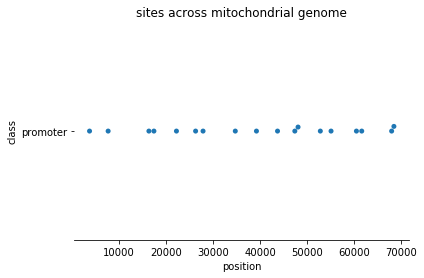

In [9]:
dataf = dfs[0]
dataf = dataf.rename(columns={'hit_id':'sys_gene_id'})
plot_sites_position_across_chromosome(dataf);
print (dataf.FASTA_id[0] + " Plot:");

Provided data read...
Arranging data for plotting...
Plot generated.

SGD_REF_mito Plot:


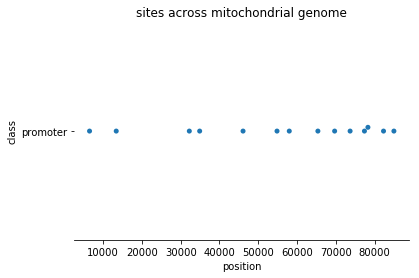

In [10]:
dataf = dfs[1]
dataf = dataf.rename(columns={'hit_id':'sys_gene_id'})
plot_sites_position_across_chromosome(dataf);
print (dataf.FASTA_id[0] + " Plot:");

Provided data read...
Arranging data for plotting...
Plot generated.

N44_mito Plot:


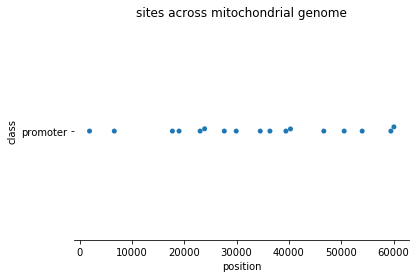

In [11]:
dataf = dfs[2]
dataf = dataf.rename(columns={'hit_id':'sys_gene_id'})
plot_sites_position_across_chromosome(dataf);
print (dataf.FASTA_id[0] + " Plot:");

Note the different x-axis spanned in each of the three plots.

----- 

Enjoy!